# AdamW Component Decomposition

**Question:** What's driving the deceleration of dead token motion?

The AdamW update rule is:
$$\Delta W = -\text{lr} \times \frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon}$$

Where:
- **Numerator:** $\hat{m} = m / (1 - \beta_1^t)$ (bias-corrected momentum)
- **Denominator:** $\sqrt{\hat{v}} + \epsilon = \sqrt{v / (1 - \beta_2^t)} + \epsilon$

We plot six curves vertically for easy visual correlation:
1. Centroid L2 distance from origin (reference)
2. Mean |ΔW′| per token (actual lattice displacement)
3. Mean |g| (raw gradient magnitude)
4. Mean |m̂| (bias-corrected momentum / numerator)
5. Mean (√v̂ + ε) (bias-corrected denominator)
6. Mean |m̂| / (√v̂ + ε) (effective step size before lr)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

# Device detection
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

# Paths
PROJECT_ROOT = Path.cwd().parent.parent.parent
CRUCIBLE_2_PATH = PROJECT_ROOT / 'box_4' / 'tensors' / 'Crucible-2' / 'crucible_2_trajectory.safetensors'

# AdamW hyperparameters
BETA1 = 0.9
BETA2 = 0.999
EPS = 1e-8

# Style
plt.rcParams['figure.dpi'] = 200
STEELBLUE = '#4682B4'

# Random seed
torch.manual_seed(42)
np.random.seed(42)

Using device: mps


In [2]:
# Load Crucible 2 trajectory data
tensors = load_file(CRUCIBLE_2_PATH)

# Convert W from uint16 bitpattern back to bfloat16, then to float32
W_uint16 = tensors['W']  # [501, 3699, 64]
W = W_uint16.view(torch.bfloat16).float()

# Other tensors are already float32
delta_W_prime = tensors['delta_W_prime']  # [500, 3699, 64] - lattice displacements
g = tensors['g']  # [500, 3699, 64] - gradients
m = tensors['m']  # [501, 3699, 64] - momentum (first moment)
v = tensors['v']  # [501, 3699, 64] - variance (second moment)

n_steps = W.shape[0]  # 501 (t=0 to t=500)
n_tokens = W.shape[1]  # 3699 dead tokens
n_dims = W.shape[2]    # 64 dimensions

print(f"Loaded trajectory: {n_steps} timesteps, {n_tokens} tokens, {n_dims} dimensions")
print(f"W shape: {W.shape}")
print(f"delta_W_prime shape: {delta_W_prime.shape}")
print(f"g shape: {g.shape}")
print(f"m shape: {m.shape}")
print(f"v shape: {v.shape}")

Loaded trajectory: 501 timesteps, 3699 tokens, 64 dimensions
W shape: torch.Size([501, 3699, 64])
delta_W_prime shape: torch.Size([500, 3699, 64])
g shape: torch.Size([500, 3699, 64])
m shape: torch.Size([501, 3699, 64])
v shape: torch.Size([501, 3699, 64])


In [3]:
# 1. Centroid L2 distance from origin
centroid = W.mean(dim=1)  # [501, 64]
centroid_norm = centroid.norm(dim=1).numpy()  # [501]

# 2. Mean |ΔW′| per token (L2 norm of displacement, averaged across tokens)
delta_W_prime_norm = delta_W_prime.norm(dim=2)  # [500, 3699]
mean_displacement = delta_W_prime_norm.mean(dim=1).numpy()  # [500]

# 3. Mean |g| (raw gradient magnitude)
g_norm = g.norm(dim=2)  # [500, 3699]
mean_g = g_norm.mean(dim=1).numpy()  # [500]

# For metrics 4-6, we need to apply bias correction
# t ranges from 1 to 500 (step number, 1-indexed for bias correction)
t = torch.arange(1, 501).float()  # [500]

# Bias correction factors: shape [500, 1, 1] for broadcasting
bias_correction_1 = (1 - BETA1 ** t).view(-1, 1, 1)  # [500, 1, 1]
bias_correction_2 = (1 - BETA2 ** t).view(-1, 1, 1)  # [500, 1, 1]

# 4. Bias-corrected momentum (numerator): m̂ = m / (1 - β₁^t)
m_hat = m[1:] / bias_correction_1  # [500, 3699, 64]
m_hat_norm = m_hat.norm(dim=2)  # [500, 3699]
mean_m_hat = m_hat_norm.mean(dim=1).numpy()  # [500]

# 5. Bias-corrected denominator: √v̂ + ε = √(v / (1 - β₂^t)) + ε
v_hat = v[1:] / bias_correction_2  # [500, 3699, 64]
sqrt_v_hat_plus_eps = torch.sqrt(v_hat) + EPS  # [500, 3699, 64]
# Take L2 norm across dimensions for each token
denom_norm = sqrt_v_hat_plus_eps.norm(dim=2)  # [500, 3699]
mean_denom = denom_norm.mean(dim=1).numpy()  # [500]

# 6. Effective step size: |m̂| / (√v̂ + ε)
# Compute per-dimension, then take L2 norm
step_size = m_hat / sqrt_v_hat_plus_eps  # [500, 3699, 64]
step_size_norm = step_size.norm(dim=2)  # [500, 3699]
mean_step_size = step_size_norm.mean(dim=1).numpy()  # [500]

print("Computed all metrics (with bias correction).")
print(f"Centroid norm range: {centroid_norm.min():.4f} to {centroid_norm.max():.4f}")
print(f"Mean displacement range: {mean_displacement.min():.4f} to {mean_displacement.max():.4f}")
print(f"Mean |g| range: {mean_g.min():.6f} to {mean_g.max():.6f}")
print(f"Mean |m̂| range: {mean_m_hat.min():.6f} to {mean_m_hat.max():.6f}")
print(f"Mean (√v̂ + ε) range: {mean_denom.min():.6f} to {mean_denom.max():.6f}")
print(f"Mean |m̂|/(√v̂ + ε) range: {mean_step_size.min():.4f} to {mean_step_size.max():.4f}")

Computed all metrics (with bias correction).
Centroid norm range: 0.0029 to 0.6357
Mean displacement range: 0.5392 to inf
Mean |g| range: 0.000019 to 0.000733
Mean |m̂| range: 0.000020 to 0.000668
Mean (√v̂ + ε) range: 0.000158 to 0.000697
Mean |m̂|/(√v̂ + ε) range: 1.2896 to 8.0048


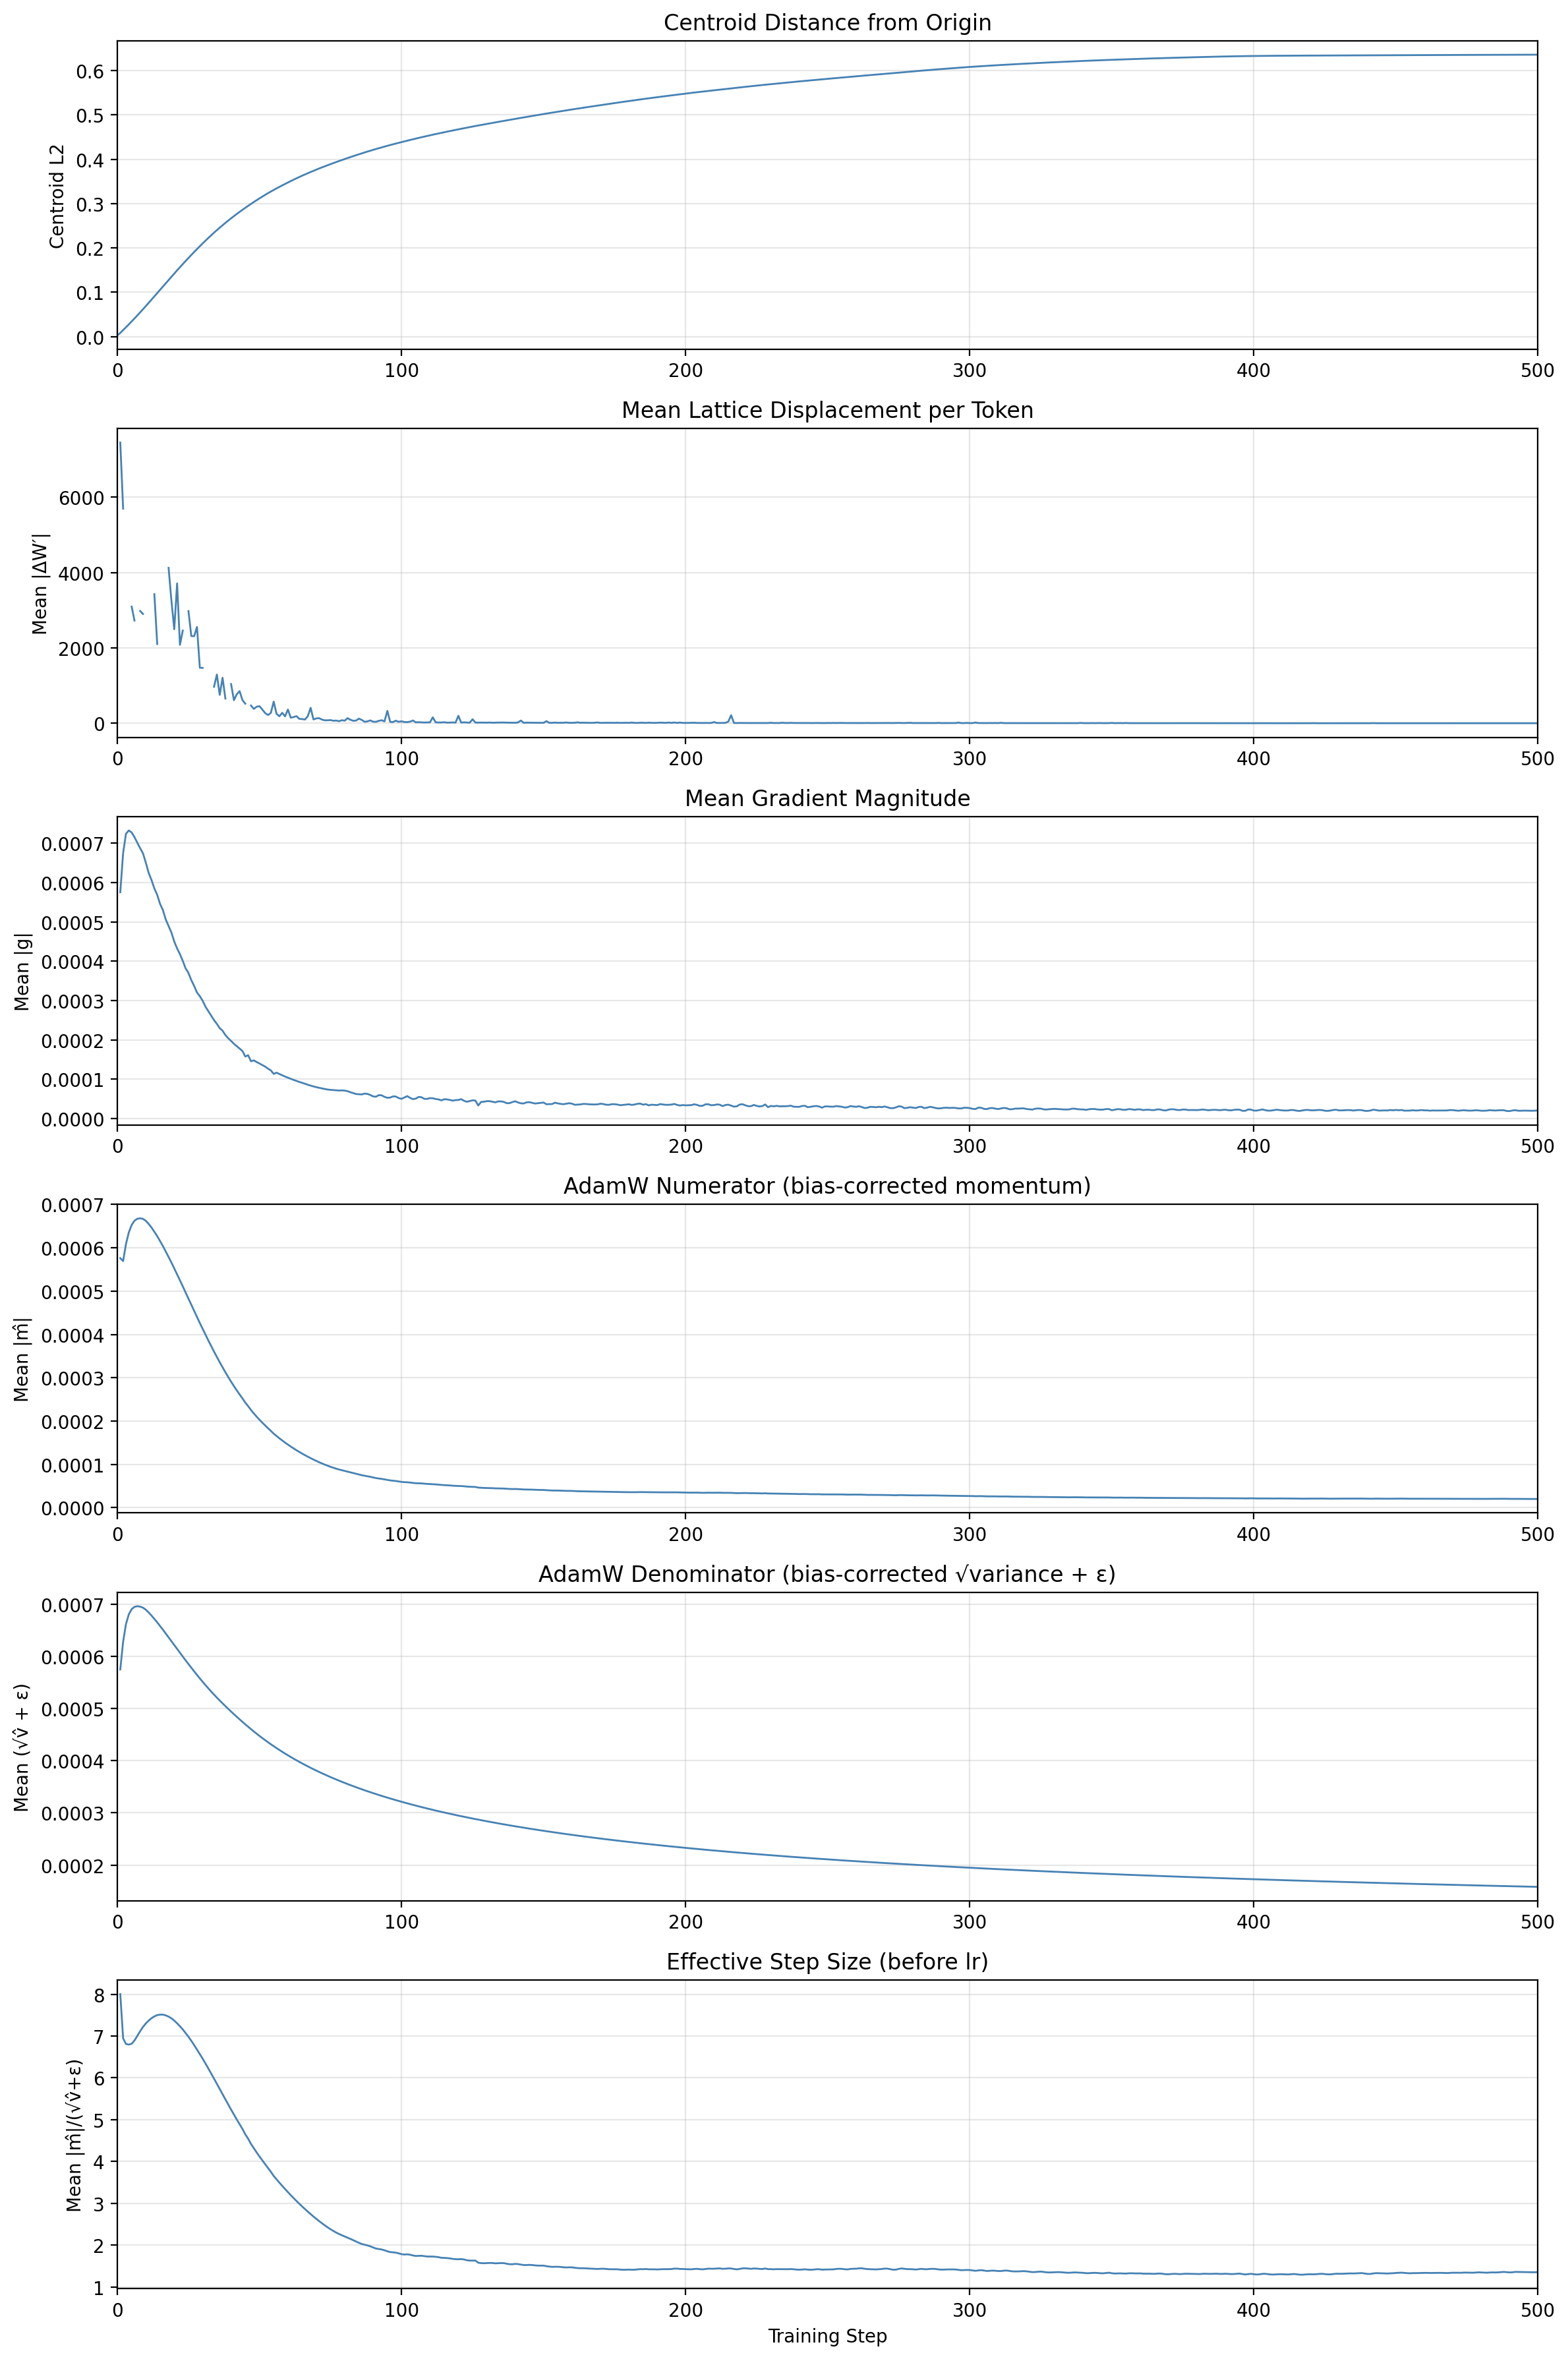

In [4]:
# Create 1x6 vertical stack of plots
fig, axes = plt.subplots(6, 1, figsize=(12, 18))

# Time axes
t_501 = np.arange(501)  # For centroid (has t=0)
t_500 = np.arange(1, 501)  # For per-step metrics (no t=0)

# Plot 1: Centroid L2 from origin
ax = axes[0]
ax.plot(t_501, centroid_norm, color=STEELBLUE, linewidth=1)
ax.set_ylabel('Centroid L2')
ax.set_title('Centroid Distance from Origin')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 500)

# Plot 2: Mean |ΔW′|
ax = axes[1]
ax.plot(t_500, mean_displacement, color=STEELBLUE, linewidth=1)
ax.set_ylabel('Mean |ΔW′|')
ax.set_title('Mean Lattice Displacement per Token')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 500)

# Plot 3: Mean |g|
ax = axes[2]
ax.plot(t_500, mean_g, color=STEELBLUE, linewidth=1)
ax.set_ylabel('Mean |g|')
ax.set_title('Mean Gradient Magnitude')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 500)

# Plot 4: Mean |m̂| (numerator)
ax = axes[3]
ax.plot(t_500, mean_m_hat, color=STEELBLUE, linewidth=1)
ax.set_ylabel('Mean |m̂|')
ax.set_title('AdamW Numerator (bias-corrected momentum)')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 500)

# Plot 5: Mean (√v̂ + ε) (denominator)
ax = axes[4]
ax.plot(t_500, mean_denom, color=STEELBLUE, linewidth=1)
ax.set_ylabel('Mean (√v̂ + ε)')
ax.set_title('AdamW Denominator (bias-corrected √variance + ε)')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 500)

# Plot 6: Mean |m̂|/(√v̂ + ε) (effective step size)
ax = axes[5]
ax.plot(t_500, mean_step_size, color=STEELBLUE, linewidth=1)
ax.set_ylabel('Mean |m̂|/(√v̂+ε)')
ax.set_title('Effective Step Size (before lr)')
ax.set_xlabel('Training Step')
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 500)

plt.tight_layout()
plt.show()

## Observations

*(To be filled in after viewing the plots)*